Enhanced Temporal Spiking ViT for MNIST initialized on cuda
=== Enhanced Temporal Spiking ViT for MNIST ===
Device: cuda
Training samples: 60000, Test samples: 10000
Hierarchical grouping: ['low_digits', 'mid_digits', 'high_digits']
Digit mapping: {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2}
Total parameters: 14,205,760
Trainable parameters: 14,205,760

Training Configuration:
Epochs: 60, Batch size: 256, Learning rate: 0.00035
Coarse loss weight: 0.3, Graph loss weight: 0.12
Memory bank size: 10240, KNN K: 8, Temperature: 0.08
EMA decay: 0.999, Gating inference: True

Starting Enhanced Training on MNIST...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train [ 1/60] | Loss 2.7499 | SpikeReg 9.5907e-08 | Graph 0.0780 | CoarseCE 1.0765 | HierKL 1.2480

Epoch [ 1/60] Test Results:
Accuracy: 0.3428 | F1: 0.2881 | ROC-AUC: 0.8475
Precision: 0.4036 | Recall: 0.3428
MAE: 1.9768 | MSE: 7.5024 | RMSE: 2.7391 | R²: 0.1053
       EMA Test Accuracy: 0.0982
Checkpoint saved: ./mnist_enhanced_snn_vit_best.pth
  → Saved new best model (acc: 0.3428)
Checkpoint saved: ./mnist_enhanced_snn_vit_ema_best.pth
  → Saved new best EMA model (acc: 0.0982)

Train [ 2/60] | Loss 1.6726 | SpikeReg 2.8795e-07 | Graph 0.3134 | CoarseCE 0.6187 | HierKL 1.2331

Epoch [ 2/60] Test Results:
Accuracy: 0.9265 | F1: 0.9276 | ROC-AUC: 0.9946
Precision: 0.9323 | Recall: 0.9265
MAE: 0.2589 | MSE: 1.2119 | RMSE: 1.1009 | R²: 0.8555
       EMA Test Accuracy: 0.0461
Checkpoint saved: ./mnist_enhanced_snn_vit_best.pth
  → Saved new best model (acc: 0.9265)

Train [ 3/60] | Loss 1.0782 | SpikeReg 7.7234e-07 | Graph 0.3989 | CoarseCE 0.3167 | HierKL 1.2249

Epoch [ 3/60] Test Re

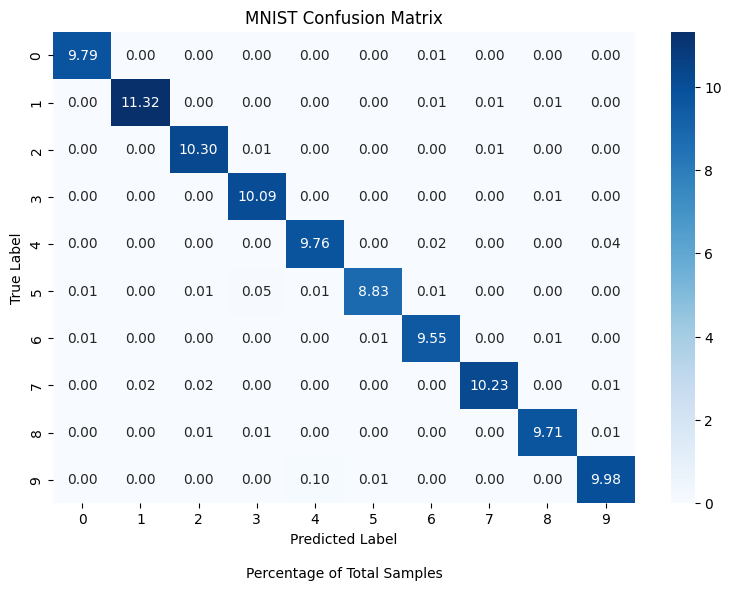

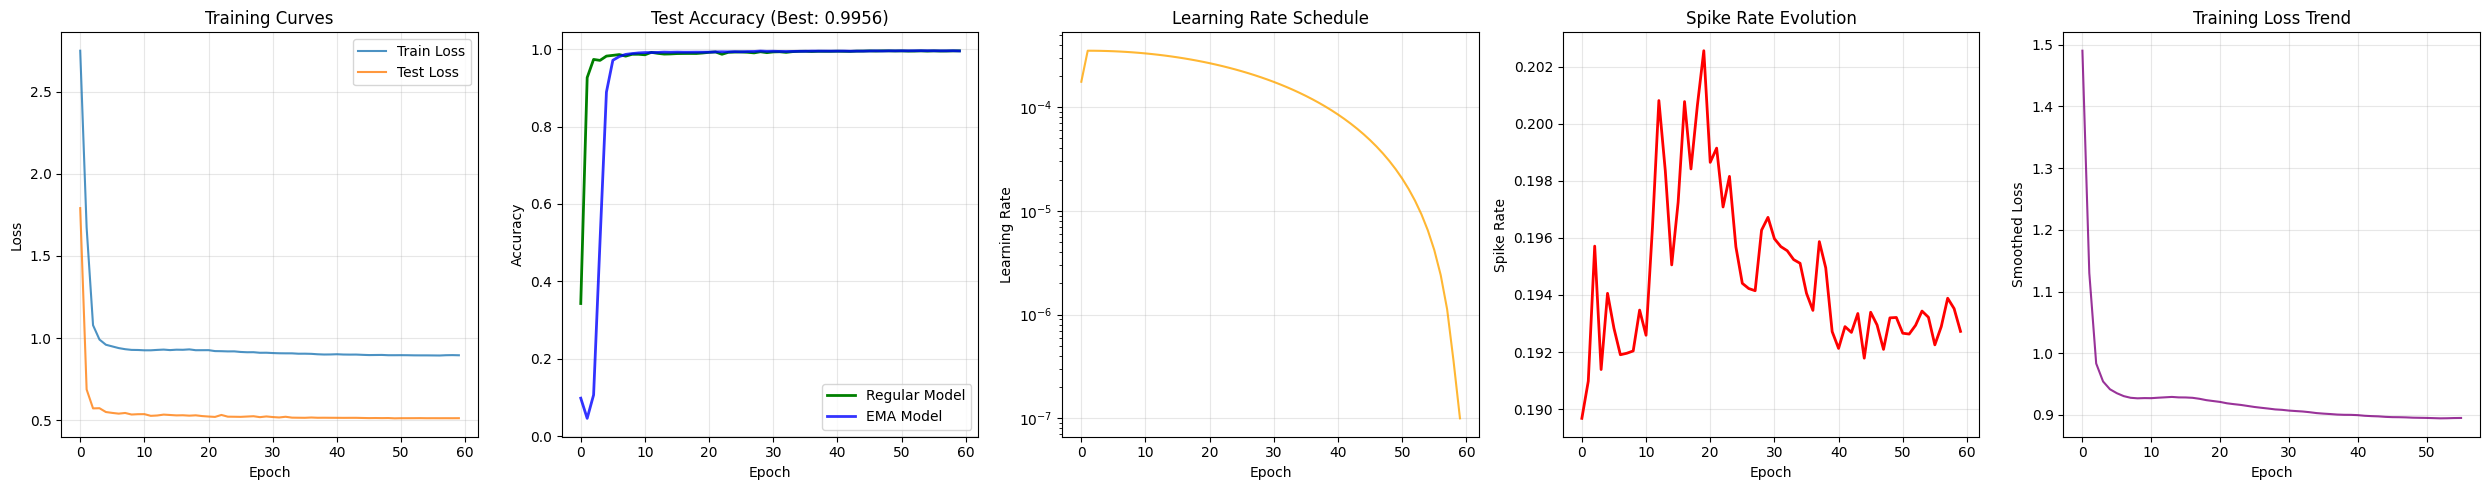


Generating model analysis...


/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


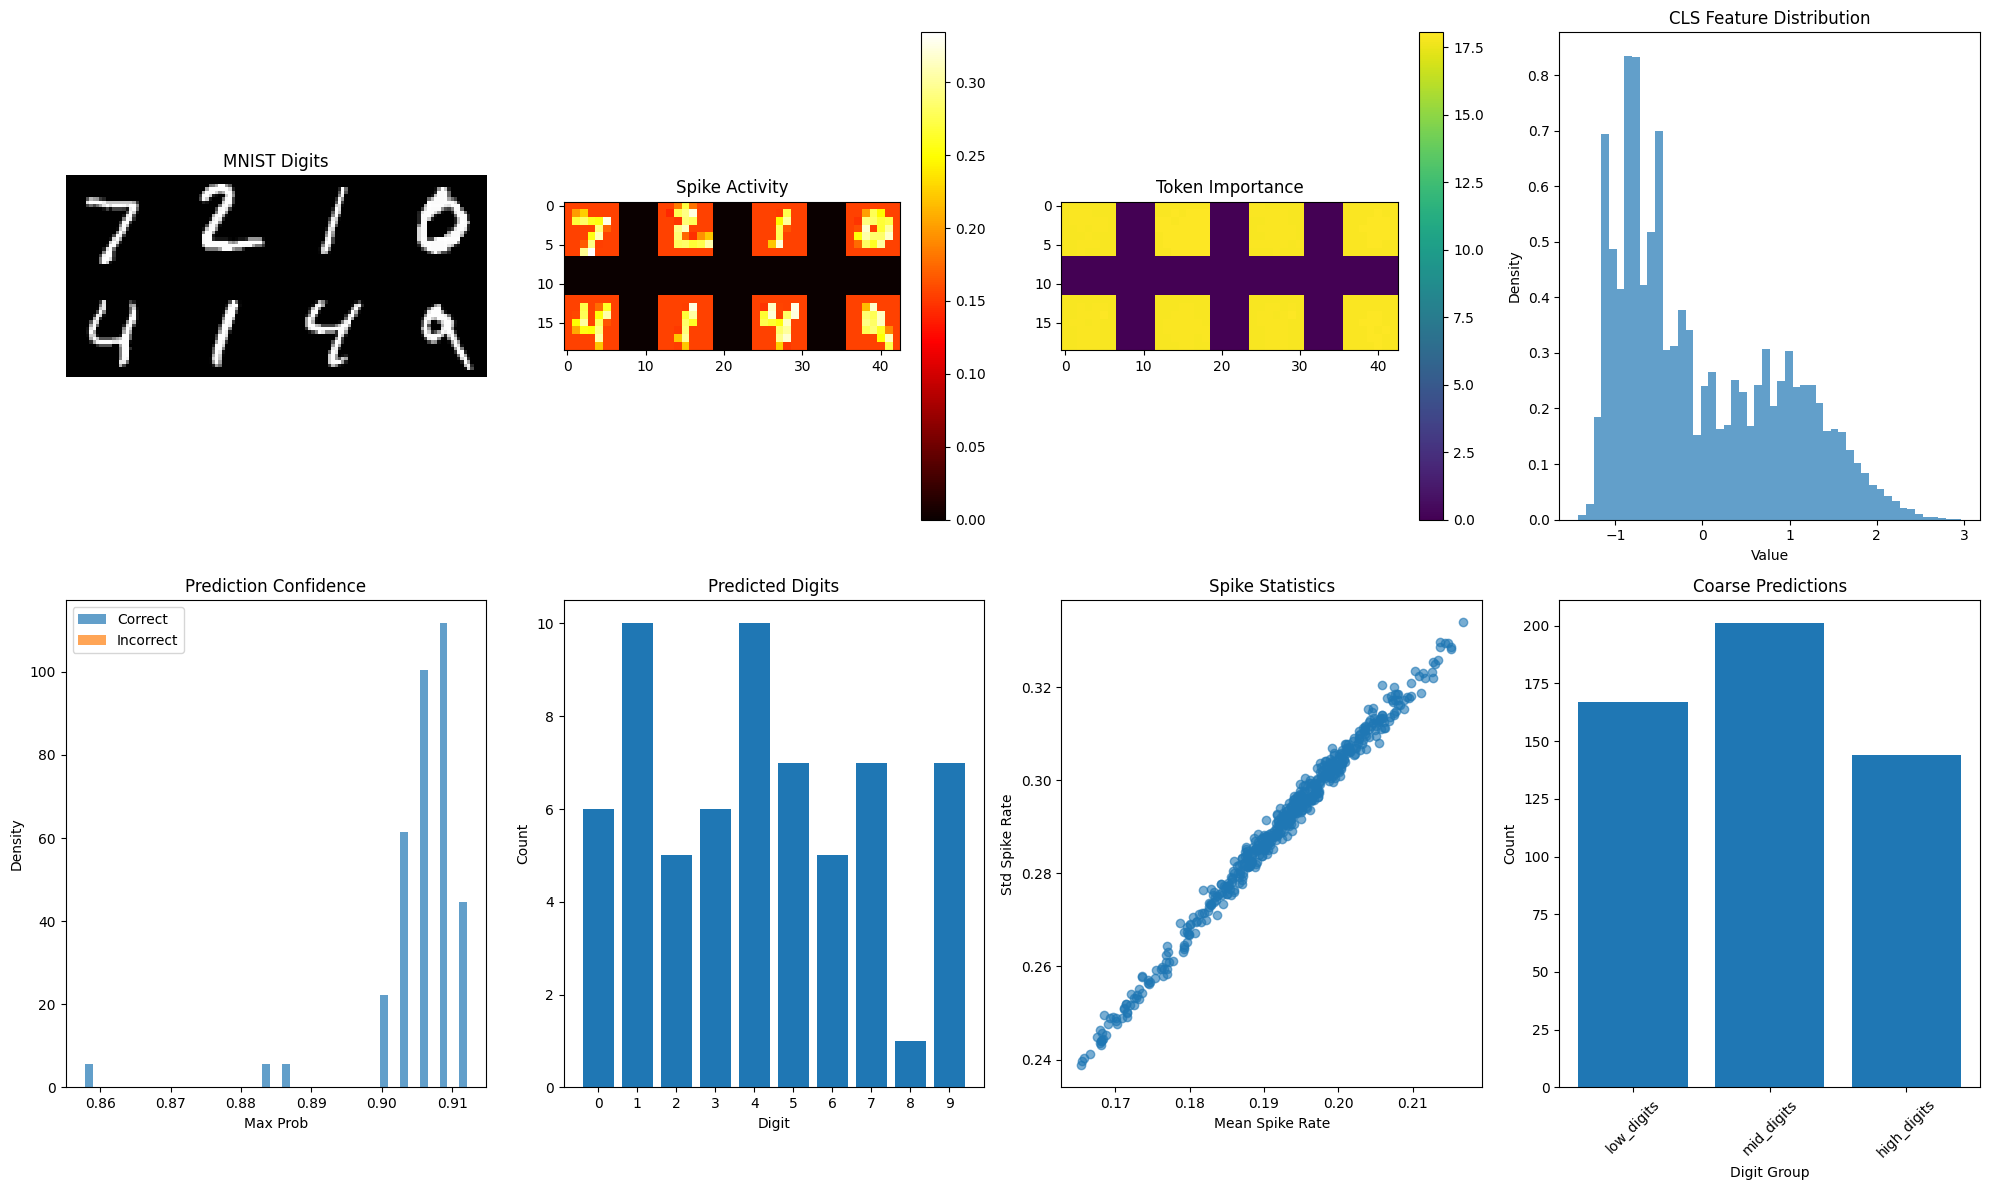

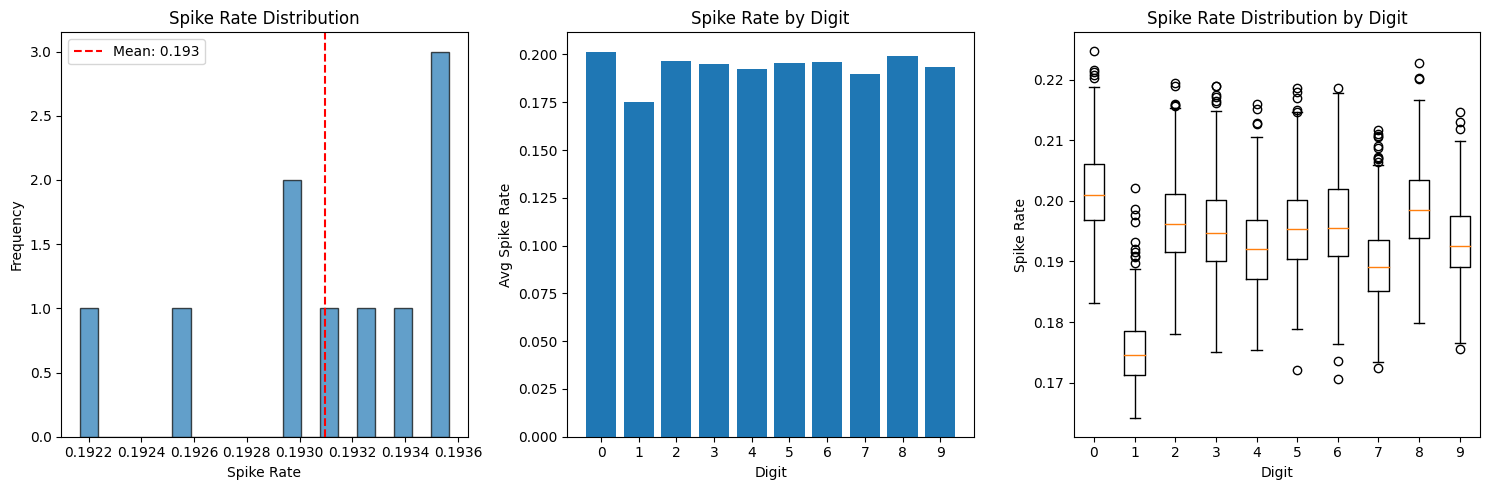

Spike Statistics:
  Mean: 0.1931 | Std: 0.0004
  Min: 0.1922 | Max: 0.1936

Testing inference speed...
Testing model inference speed...
Inference Results (100 samples):
  Avg time: 14.43 ms | Accuracy: 1.0000
  Throughput: 69.3 samples/sec

Detailed Analysis by Digit Groups:
  low_digits (digits [0, 1, 2]): 0.9981 (3141/3147)
  mid_digits (digits [3, 4, 5, 6]): 0.9951 (3823/3842)
  high_digits (digits [7, 8, 9]): 0.9937 (2992/3011)

Classification Report:
              precision    recall  f1-score   support

     Digit 0       1.00      1.00      1.00       980
     Digit 1       1.00      1.00      1.00      1135
     Digit 2       1.00      1.00      1.00      1032
     Digit 3       0.99      1.00      1.00      1010
     Digit 4       0.99      0.99      0.99       982
     Digit 5       1.00      0.99      0.99       892
     Digit 6       0.99      1.00      1.00       958
     Digit 7       1.00      1.00      1.00      1028
     Digit 8       1.00      1.00      1.00       974

In [6]:
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Complete Enhanced Temporal Spiking ViT for MNIST (Fixed)
======================================================
Features: Hierarchical digit classification, graph consistency, comprehensive evaluation
Author: Enhanced implementation with fixed tensor copying warnings
Dataset: MNIST handwritten digits (0-9)
Hierarchy: low_digits(0-2), mid_digits(3-6), high_digits(7-9)
"""

import math, torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np, seaborn as sns, time, gc
from sklearn.metrics import (precision_recall_fscore_support, roc_auc_score, mean_absolute_error, 
                           mean_squared_error, r2_score, confusion_matrix, classification_report)
from sklearn.preprocessing import label_binarize

# ================================
# HYPERPARAMETERS FOR MNIST
# ================================
EMBED_DIM = 384; NUM_BLOCKS = 8; NUM_HEADS = 8; MLP_RATIO = 4.0; PATCH_SIZE = 4
T_PATCH = 6; T_ATTN = 2; T_MLP = 2; DROPOUT = 0.12; DROPPATH = 0.12
WEIGHT_DECAY = 0.04; LR = 3.5e-4; EPOCHS = 60; BATCH_TRAIN = 256; BATCH_TEST = 512
LABEL_SMOOTH = 0.1; CLIP_NORM = 0.8; WARMUP_EPOCHS = 2
COARSE_LOSS_W = 0.3; GRAPH_LOSS_W = 0.12; KNN_K = 8; TAU = 0.08
BANK_SIZE = 10240; GATING_INFER = True; EMA_DECAY = 0.999

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available(): 
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

# MNIST hierarchical grouping: low(0-2), mid(3-6), high(7-9)
COARSE_NAMES = ["low_digits", "mid_digits", "high_digits"]
PARENT_MAP = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:2, 8:2, 9:2}

print(f"Enhanced Temporal Spiking ViT for MNIST initialized on {device}")

# ================================
# CORE NEURAL COMPONENTS
# ================================
class OptimizedSurrogateSpike(torch.autograd.Function):
    """Temperature-controlled surrogate gradient for spiking neurons"""
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        out = (x >= 0).float()
        # Ensure temperature is a tensor and on the correct device
        if not isinstance(temperature, torch.Tensor):
            temperature = torch.tensor(temperature, device=x.device, dtype=torch.float32)
        else:
            temperature = temperature.clone().detach().to(device=x.device, dtype=torch.float32)
        ctx.save_for_backward(x, temperature)
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 3.0 / temp
        grad = alpha * torch.sigmoid(alpha * x) * (1 - torch.sigmoid(alpha * x))
        return grad_out * grad, None

spike_fn = OptimizedSurrogateSpike.apply

class EnhancedAdaptiveLIFNeuron(nn.Module):
    """Adaptive Leaky Integrate-and-Fire neuron with learnable parameters"""
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay, dtype=torch.float32)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th, dtype=torch.float32)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale, dtype=torch.float32)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1: 
            return spike_fn(x - self.v_th, self.temp_scale)
        
        batch_size = x.shape[0]
        mem = x.new_zeros(x.shape)
        spike_train = []
        
        for t in range(T):
            mem = torch.clamp(self.decay * mem + x, min=-2*self.v_th, max=3*self.v_th)
            z = mem - self.v_th
            s = spike_fn(z, self.temp_scale)
            mem = mem * (1 - s)  # Hard reset
            spike_train.append(s)
        
        weights = torch.softmax(torch.linspace(0.5, 1.0, T, device=x.device), dim=0)
        weighted_sum = sum(w * s for w, s in zip(weights, spike_train))
        return weighted_sum

class OptimizedDropPath(nn.Module):
    """Stochastic depth for regularization"""
    def __init__(self, drop_prob=0.1, scale_by_keep=True):
        super().__init__()
        self.drop_prob = float(drop_prob)
        self.scale_by_keep = scale_by_keep
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0.0: 
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        if self.scale_by_keep: 
            mask = mask / keep_prob
        return x * mask

class CachedPositionalEmbedding(nn.Module):
    """Cached 2D sinusoidal positional embeddings for efficiency"""
    def __init__(self, max_h=32, max_w=32, dim=EMBED_DIM):
        super().__init__()
        self.dim = dim
        self.max_h = max_h
        self.max_w = max_w
        self._cache = {}
        
    def get_2d_sincos_pos_embed(self, nh, nw, device):
        key = (nh, nw, device)
        if key not in self._cache:
            assert self.dim % 2 == 0, "embed dim must be even for 2D sincos"
            
            def pe(n, d):
                pos = torch.arange(n, device=device, dtype=torch.float32)[:, None]
                div = torch.exp(torch.arange(0, d, 2, device=device, dtype=torch.float32) * (-math.log(10000.0) / d))
                out = torch.zeros(n, d, device=device, dtype=torch.float32)
                out[:, 0::2] = torch.sin(pos * div)
                out[:, 1::2] = torch.cos(pos * div)
                return out
                
            d_half = self.dim // 2
            ph = pe(nh, d_half)
            pw = pe(nw, d_half)
            ph_rep = ph[:, None, :].repeat(1, nw, 1).reshape(nh * nw, d_half)
            pw_rep = pw[None, :, :].repeat(nh, 1, 1).reshape(nh * nw, d_half)
            pe_2d = torch.cat([ph_rep, pw_rep], dim=1)
            self._cache[key] = pe_2d
            
        return self._cache[key]

# ================================
# MODEL COMPONENTS
# ================================
class EnhancedPatchEmbed(nn.Module):
    """Patch embedding with spiking dynamics"""
    def __init__(self, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)
        self.lif = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=1.0, learnable=True, temp_scale=0.8)
        self.T = T
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)
        feat = self.norm(feat)
        spikes = self.lif(feat, T=self.T)
        B, C, H, W = spikes.shape
        tokens = spikes.view(B, C, H * W).permute(0, 2, 1)
        return tokens, (H, W), spikes

class EnhancedTransformerBlock(nn.Module):
    """Transformer block with spiking neurons"""
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO, 
                 attn_dropout=0.0, dropout=DROPOUT, droppath=DROPPATH, T_attn=T_ATTN, T_mlp=T_MLP):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        # Attention components
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        self.drop1 = OptimizedDropPath(droppath)
        
        # MLP components
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim)
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        # Spiking neurons
        self.snn_attn = EnhancedAdaptiveLIFNeuron(decay=0.8, v_th=0.8, learnable=True, temp_scale=0.9)
        self.snn_mlp = EnhancedAdaptiveLIFNeuron(decay=0.85, v_th=0.9, learnable=True, temp_scale=0.9)
        self.T_attn = T_attn
        self.T_mlp = T_mlp
        
        # Weight initialization
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Self-attention with spiking
        y = self.norm1(x)
        qkv_bias = torch.cat([self.q_bias, torch.zeros_like(self.v_bias), self.v_bias])
        qkv = F.linear(y, self.qkv.weight, qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        y = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = self.proj(y)
        y = self.proj_drop(y)
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        # MLP with spiking
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

class EnhancedSNN_ViT_MNIST(nn.Module):
    """Complete Spiking Vision Transformer for MNIST"""
    def __init__(self, num_classes=10, in_channels=1, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO, 
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        
        # Patch embedding
        self.patch = EnhancedPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        self.pos_embed = CachedPositionalEmbedding(dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks with stochastic depth
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        self.blocks = nn.ModuleList([
            EnhancedTransformerBlock(embed_dim, num_heads, mlp_ratio, 
                                   attn_dropout=0.0, dropout=dropout, droppath=dpr[i], 
                                   T_attn=T_ATTN, T_mlp=T_MLP)
            for i in range(num_blocks)
        ])
        
        # Output layers
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, num_classes)
        )
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, 3)  # 3-way coarse classification
        )
        
        self._init_weights()
        
    def _init_weights(self):
        """Initialize model weights"""
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, return_aux=False):
        # Patch embedding
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        # Add positional embedding
        pos = self.pos_embed.get_2d_sincos_pos_embed(Hp, Wp, tokens.device)
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        
        # Add CLS token
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        # Add positional embedding (zero for CLS token)
        zero_cls = torch.zeros(B, 1, self.embed_dim, device=tokens.device)
        pos_full = torch.cat([zero_cls, pos], dim=1)
        x = self.pos_drop(x + pos_full)
        
        # Transformer blocks
        for blk in self.blocks:
            x = blk(x)
            
        # Final normalization and prediction
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        aux = {
            "conv_spikes": conv_spikes,
            "cls": cls_repr,
            "coarse_logits": coarse_logits,
            "patch_tokens": x[:, 1:]
        }
        return (fine_logits, aux) if return_aux else (fine_logits, None)

# ================================
# UTILITY CLASSES
# ================================
class EnhancedMemoryBank:
    """Memory bank for graph consistency learning"""
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = torch.empty(0, dim, device=device, dtype=torch.float32)
        self.probs = torch.empty(0, num_classes, device=device, dtype=torch.float32)
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        """Add features and predictions to memory bank"""
        feats = F.normalize(feats.detach(), dim=1, p=2)
        probs = torch.softmax(logits.detach(), dim=-1)
        batch_size = feats.size(0)
        
        if self.feats.size(0) == 0:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float32)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float32)
            
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        """K-nearest neighbor search"""
        if len(self) == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size]
        active_probs = self.probs[:active_size]
        
        sim = torch.mm(feats, active_feats.t())
        k = min(k, active_size)
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        return w, neigh_probs

def build_gate_matrix():
    """Build gating matrix for hierarchical classification"""
    G = torch.zeros(3, 10, dtype=torch.float32)  # 3 coarse classes, 10 fine classes
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

class EMAModel:
    """Exponential Moving Average model for stable training"""
    def __init__(self, model, decay=EMA_DECAY):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
            
    def update(self, model):
        """Update EMA parameters"""
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        """Apply EMA parameters to model"""
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        """Restore original parameters"""
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

# ================================
# TRAINING UTILITIES
# ================================
def enhanced_laplacian_loss(curr_probs, bank_weights, bank_probs, temperature=0.5):
    """Graph consistency loss using memory bank"""
    if bank_weights is None or bank_probs is None:
        return torch.tensor(0.0, device=curr_probs.device)
    
    curr_probs_smooth = torch.softmax(curr_probs / temperature, dim=-1)
    bank_probs_smooth = torch.softmax(bank_probs / temperature, dim=-1)
    kl_div = F.kl_div(curr_probs_smooth.log().unsqueeze(1), 
                      bank_probs_smooth, reduction='none').sum(dim=-1)
    return (bank_weights * kl_div).mean()

def build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR):
    """Cosine annealing scheduler with warmup"""
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (min_lr / base_lr) + (1 - min_lr / base_lr) * cosine
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def get_mnist_transforms():
    """MNIST data transforms"""
    MNIST_MEAN, MNIST_STD = 0.1307, 0.3081
    
    transform_train = transforms.Compose([
        transforms.RandomRotation(10, fill=0),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), fill=0),
        transforms.ToTensor(),
        transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
    ])
    
    return transform_train, transform_test

# ================================
# COMPREHENSIVE EVALUATION SUITE
# ================================
@torch.no_grad()
def compute_comprehensive_metrics(model, loader, criterion_fine, apply_gating=True):
    """Compute all evaluation metrics"""
    model.eval()
    all_preds, all_targets, all_probs = [], [], []
    total_loss = 0.0
    
    gate_mat = build_gate_matrix().to(device) if apply_gating else None
    
    for data, target in loader:
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        fine_logits, aux = model(data, return_aux=True)
        loss = criterion_fine(fine_logits, target)
        
        probs = torch.softmax(fine_logits, dim=-1)
        
        if apply_gating and gate_mat is not None:
            coarse_logits = aux["coarse_logits"]
            cprob = torch.softmax(coarse_logits, dim=-1)
            gate = cprob @ gate_mat
            gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
            probs = (probs * gate).clamp_min(1e-12)
            probs = probs / probs.sum(dim=1, keepdim=True)
        
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(probs.argmax(dim=1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        total_loss += float(loss.item())
    
    y_true = np.array(all_targets)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)
    
    accuracy = (y_true == y_pred).mean()
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0)
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    try:
        y_true_bin = label_binarize(y_true, classes=range(10))
        roc_auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr', average='macro')
    except:
        roc_auc = 0.0
    
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'loss': total_loss / len(loader), 'accuracy': accuracy,
        'precision_macro': precision_macro, 'precision_weighted': precision_weighted,
        'recall_macro': recall_macro, 'recall_weighted': recall_weighted,
        'f1_macro': f1_macro, 'f1_weighted': f1_weighted,
        'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2, 'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

def print_comprehensive_results(metrics, title="Results"):
    """Print formatted results"""
    print(f"\n{title}:")
    print(f"Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1_weighted']:.4f} | ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"Precision: {metrics['precision_weighted']:.4f} | Recall: {metrics['recall_weighted']:.4f}")
    print(f"MAE: {metrics['mae']:.4f} | MSE: {metrics['mse']:.4f} | RMSE: {metrics['rmse']:.4f} | R²: {metrics['r2']:.4f}")

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Plot confusion matrix with percentages"""
    plt.figure(figsize=(8, 6))
    cm_percent = cm.astype('float') / cm.sum() * 100
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10), annot_kws={"size": 10})
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.text(0.5, -0.15, 'Percentage of Total Samples', ha='center', va='center', 
             transform=plt.gca().transAxes, fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_training_curves(train_losses, test_losses, test_accs, ema_accs=None, learning_rates=None, spike_rates=None):
    """Plot comprehensive training curves"""
    fig_width = 25 if ema_accs and spike_rates else 20 if spike_rates else 15
    n_plots = 5 if ema_accs and spike_rates else 4 if spike_rates else 3
    
    plt.figure(figsize=(fig_width, 5))
    
    # Loss curves
    plt.subplot(1, n_plots, 1)
    plt.plot(train_losses, label='Train Loss', alpha=0.8)
    plt.plot(test_losses, label='Test Loss', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy curves
    plt.subplot(1, n_plots, 2)
    plt.plot(test_accs, label='Regular Model', color='green', linewidth=2)
    if ema_accs:
        plt.plot(ema_accs, label='EMA Model', color='blue', linewidth=2, alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Test Accuracy (Best: {max(test_accs) if test_accs else 0:.4f})')
    if ema_accs:
        plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Learning rate schedule
    if learning_rates:
        plt.subplot(1, n_plots, 3)
        plt.plot(learning_rates, color='orange', alpha=0.8)
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
    
    # Spike rate evolution
    if spike_rates:
        plot_idx = 4 if learning_rates else 3
        plt.subplot(1, n_plots, plot_idx)
        plt.plot(spike_rates, color='red', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Spike Rate')
        plt.title('Spike Rate Evolution')
        plt.grid(True, alpha=0.3)
    
    # Smoothed loss trend
    if ema_accs and spike_rates:
        plt.subplot(1, n_plots, 5)
        smoothed_loss = np.convolve(train_losses, np.ones(min(5, len(train_losses)))/min(5, len(train_losses)), mode='valid')
        plt.plot(smoothed_loss, color='purple', alpha=0.8)
        plt.xlabel('Epoch')
        plt.ylabel('Smoothed Loss')
        plt.title('Training Loss Trend')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ================================
# ANALYSIS AND VISUALIZATION
# ================================
def visualize_model_analysis(model, test_loader):
    """Comprehensive model behavior visualization"""
    model.eval()
    data_iter = iter(test_loader)
    try:
        data, targets = next(data_iter)
    except StopIteration:
        print("Test loader is empty. Skipping visualization.")
        return
    
    data, targets = data.to(device), targets.to(device)
    
    with torch.no_grad():
        fine_logits, aux = model(data, return_aux=True)
        conv_spikes = aux["conv_spikes"]
        cls_features = aux["cls"]
        patch_tokens = aux["patch_tokens"]
    
    plt.figure(figsize=(20, 12))
    
    # Input images (MNIST specific)
    plt.subplot(2, 4, 1)
    sample_imgs = data[:8].cpu()
    mean, std = 0.1307, 0.3081
    sample_imgs = sample_imgs * std + mean
    sample_imgs = torch.clamp(sample_imgs, 0, 1)
    
    grid = torch.zeros(28*2 + 5, 28*4 + 15)
    for i in range(min(8, len(sample_imgs))):
        row, col = i // 4, i % 4
        start_h, start_w = row * 33, col * 33
        grid[start_h:start_h+28, start_w:start_w+28] = sample_imgs[i].squeeze()
    
    plt.imshow(grid, cmap='gray')
    plt.title('MNIST Digits')
    plt.axis('off')
    
    # Spike activity heatmap
    plt.subplot(2, 4, 2)
    spike_mean = conv_spikes[:8].mean(dim=1).cpu()
    grid_spikes = torch.zeros(7*2 + 5, 7*4 + 15)
    
    for i in range(min(8, len(spike_mean))):
        row, col = i // 4, i % 4
        start_h, start_w = row * 12, col * 12
        grid_spikes[start_h:start_h+7, start_w:start_w+7] = spike_mean[i]
    
    plt.imshow(grid_spikes, cmap='hot')
    plt.title('Spike Activity')
    plt.colorbar()
    
    # Token importance
    plt.subplot(2, 4, 3)
    patch_norms = torch.norm(patch_tokens[:8], dim=-1).cpu()
    grid_attn = torch.zeros(7*2 + 5, 7*4 + 15)
    for i in range(min(8, len(patch_norms))):
        row, col = i // 4, i % 4
        start_h, start_w = row * 12, col * 12
        grid_attn[start_h:start_h+7, start_w:start_w+7] = patch_norms[i].view(7, 7)
    
    plt.imshow(grid_attn, cmap='viridis')
    plt.title('Token Importance')
    plt.colorbar()
    
    # Feature distribution
    plt.subplot(2, 4, 4)
    cls_feat_cpu = cls_features[:64].cpu().numpy()
    plt.hist(cls_feat_cpu.flatten(), bins=50, alpha=0.7, density=True)
    plt.title('CLS Feature Distribution')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # Prediction confidence
    plt.subplot(2, 4, 5)
    probs = torch.softmax(fine_logits[:64], dim=-1)
    max_probs = probs.max(dim=-1)[0].cpu().numpy()
    pred_correct = (fine_logits[:64].argmax(dim=1) == targets[:64]).cpu().numpy()
    
    plt.hist([max_probs[pred_correct], max_probs[~pred_correct]], 
             bins=20, alpha=0.7, label=['Correct', 'Incorrect'], density=True)
    plt.title('Prediction Confidence')
    plt.xlabel('Max Prob')
    plt.ylabel('Density')
    plt.legend()
    
    # Class distribution
    plt.subplot(2, 4, 6)
    pred_classes = fine_logits[:64].argmax(dim=1).cpu().numpy()
    class_counts = np.bincount(pred_classes, minlength=10)
    plt.bar(range(10), class_counts)
    plt.title('Predicted Digits')
    plt.xlabel('Digit')
    plt.ylabel('Count')
    plt.xticks(range(10))
    
    # Spike statistics
    plt.subplot(2, 4, 7)
    spike_stats = conv_spikes.view(conv_spikes.size(0), -1).cpu()
    spike_means = spike_stats.mean(dim=1).numpy()
    spike_stds = spike_stats.std(dim=1).numpy()
    plt.scatter(spike_means, spike_stds, alpha=0.6)
    plt.xlabel('Mean Spike Rate')
    plt.ylabel('Std Spike Rate')
    plt.title('Spike Statistics')
    
    # Coarse vs Fine predictions
    plt.subplot(2, 4, 8)
    coarse_logits = aux["coarse_logits"]
    coarse_preds = coarse_logits.argmax(dim=1).cpu().numpy()
    coarse_counts = np.bincount(coarse_preds, minlength=3)
    plt.bar(range(3), coarse_counts)
    plt.title('Coarse Predictions')
    plt.xlabel('Digit Group')
    plt.ylabel('Count')
    plt.xticks(range(3), COARSE_NAMES, rotation=45)
    
    plt.tight_layout()
    plt.show()

def analyze_spiking_activity(model, test_loader):
    """Detailed spike rate analysis"""
    model.eval()
    spike_rates, class_spikes = [], {i: [] for i in range(10)}
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= 10:
                break
            data, target = data.to(device), target.to(device)
            _, aux = model(data, return_aux=True)
            
            conv_spikes = aux["conv_spikes"]
            spike_rate = conv_spikes.mean().item()
            spike_rates.append(spike_rate)
            
            for j, class_idx in enumerate(target.cpu().numpy()):
                if j < conv_spikes.size(0):
                    class_spike_rate = conv_spikes[j].mean().item()
                    class_spikes[class_idx].append(class_spike_rate)
    
    plt.figure(figsize=(15, 5))
    
    # Overall spike rate distribution
    plt.subplot(1, 3, 1)
    plt.hist(spike_rates, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(spike_rates), color='red', linestyle='--', 
                label=f'Mean: {np.mean(spike_rates):.3f}')
    plt.xlabel('Spike Rate')
    plt.ylabel('Frequency')
    plt.title('Spike Rate Distribution')
    plt.legend()
    
    # Spike rate by digit
    plt.subplot(1, 3, 2)
    class_means = [np.mean(rates) if rates else 0 for rates in class_spikes.values()]
    plt.bar(range(10), class_means)
    plt.xlabel('Digit')
    plt.ylabel('Avg Spike Rate')
    plt.title('Spike Rate by Digit')
    plt.xticks(range(10))
    
    # Box plot of spike rates by digit
    plt.subplot(1, 3, 3)
    plt.boxplot([class_spikes[i] if class_spikes[i] else [0] for i in range(10)])
    plt.xlabel('Digit')
    plt.ylabel('Spike Rate')
    plt.title('Spike Rate Distribution by Digit')
    plt.xticks(range(1, 11), range(10))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Spike Statistics:")
    print(f"  Mean: {np.mean(spike_rates):.4f} | Std: {np.std(spike_rates):.4f}")
    print(f"  Min: {np.min(spike_rates):.4f} | Max: {np.max(spike_rates):.4f}")

def test_model_inference(model_path='./mnist_enhanced_snn_vit_best.pth'):
    """Test model inference speed and accuracy"""
    print("Testing model inference speed...")
    
    try:
        model = EnhancedSNN_ViT_MNIST().to(device)
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['state_dict'])
        model.eval()
        
        _, transform_test = get_mnist_transforms()
        test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform_test)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        
        times, correct, total = [], 0, 0
        
        with torch.no_grad():
            for i, (data, target) in enumerate(test_loader):
                if i >= 100:
                    break
                data, target = data.to(device), target.to(device)
                
                start_time = time.time()
                logits, _ = model(data, return_aux=False)
                end_time = time.time()
                
                times.append(end_time - start_time)
                pred = logits.argmax(dim=1)
                correct += (pred == target).sum().item()
                total += 1
        
        avg_time = np.mean(times) * 1000
        accuracy = correct / total if total > 0 else 0
        
        print(f"Inference Results (100 samples):")
        print(f"  Avg time: {avg_time:.2f} ms | Accuracy: {accuracy:.4f}")
        print(f"  Throughput: {1000/avg_time:.1f} samples/sec")
    
    except Exception as e:
        print(f"Error during inference testing: {e}")

def save_model_checkpoint(model, optimizer, epoch, best_acc, loss, filepath, config=None):
    """Save comprehensive model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict() if optimizer else None,
        'best_accuracy': best_acc,
        'loss': loss,
        'hyperparameters': {
            'embed_dim': EMBED_DIM,
            'num_blocks': NUM_BLOCKS,
            'num_heads': NUM_HEADS,
            'mlp_ratio': MLP_RATIO,
            'patch_size': PATCH_SIZE,
            'dropout': DROPOUT,
        }
    }
    if config:
        checkpoint.update(config)
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved: {filepath}")

# ================================
# TRAINING FUNCTIONS
# ================================
def train_one_epoch_enhanced(model, ema_model, loader, optimizer, scaler, scheduler, 
                           criterion_fine, criterion_coarse, bank, epoch, total_epochs):
    """Enhanced training loop with comprehensive loss components"""
    model.train()
    run_loss, run_srl, run_graph, run_coarse, run_hier = 0.0, 0.0, 0.0, 0.0, 0.0
    n_batches = 0
    
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.4 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast(device_type='cuda', enabled=(device == "cuda")):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            ce_fine = criterion_fine(fine_logits, target)
            
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            fine_probs = torch.softmax(fine_logits, dim=-1)
            coarse_probs = torch.softmax(coarse_logits, dim=-1)
            gate_mat = build_gate_matrix().to(device)
            expected_coarse = fine_probs @ gate_mat.t()
            hier_loss = F.kl_div(expected_coarse.log(), coarse_probs, reduction='batchmean')
            
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                current_rate = conv_spikes.mean()
                target_rate = 0.12 + 0.08 * math.exp(-epoch / 8)
                srl = (current_rate - target_rate).pow(2) * 2e-3
            else:
                srl = torch.tensor(0.0, device=device)
            
            with torch.no_grad():
                w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU) if bank is not None else (None, None)
            g_loss = enhanced_laplacian_loss(fine_logits, w, neigh_probs) if bank is not None else torch.tensor(0.0, device=device)
            
            loss = (ce_fine + coarse_weight * ce_coarse + 0.2 * hier_loss + graph_weight * g_loss + srl)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        if scheduler is not None:
            scheduler.step()
        scaler.update()
        
        if ema_model is not None:
            ema_model.update(model)
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        run_loss += float(loss.item())
        run_srl += float(srl.item())
        run_graph += float(g_loss.item())
        run_coarse += float(ce_coarse.item())
        run_hier += float(hier_loss.item())
        n_batches += 1
    
    avg_loss = run_loss / max(1, n_batches)
    print(f"Train [{epoch:2d}/{total_epochs}] | Loss {avg_loss:.4f} | SpikeReg {run_srl/n_batches:.4e} | "
          f"Graph {run_graph/n_batches:.4f} | CoarseCE {run_coarse/n_batches:.4f} | HierKL {run_hier/n_batches:.4f}")
    return avg_loss

# ================================
# MAIN TRAINING EXECUTION
# ================================
def main_mnist():
    """Main training function with comprehensive evaluation"""
    print("=== Enhanced Temporal Spiking ViT for MNIST ===")
    print(f"Device: {device}")
    
    # Data preparation
    transform_train, transform_test = get_mnist_transforms()
    
    try:
        train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform_train)
        test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform_test)
    except Exception as e:
        print(f"Error loading MNIST dataset: {e}")
        return None, 0.0, {}
    
    pin = torch.cuda.is_available()
    num_workers = min(8, torch.get_num_threads()) if pin else 0
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True,  
                             num_workers=num_workers, pin_memory=pin, persistent_workers=num_workers > 0, 
                             prefetch_factor=2 if num_workers > 0 else 2)
    
    test_loader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=False, 
                            num_workers=num_workers, pin_memory=pin, persistent_workers=num_workers > 0, 
                            prefetch_factor=2 if num_workers > 0 else 2)
    
    print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
    print(f"Hierarchical grouping: {COARSE_NAMES}")
    print(f"Digit mapping: {PARENT_MAP}")
    
    # Model initialization
    model = EnhancedSNN_ViT_MNIST().to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Training setup
    param_groups = [
        {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'norm' not in n], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'norm' in n], 'weight_decay': 0.0}
    ]
    
    optimizer = optim.AdamW(param_groups, lr=LR, betas=(0.9, 0.95), eps=1e-8)
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    scaler = torch.amp.GradScaler('cuda', enabled=(device == "cuda"))
    
    steps_per_epoch = len(train_loader)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = WARMUP_EPOCHS * steps_per_epoch
    scheduler = build_enhanced_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7, base_lr=LR)
    
    ema_model = EMAModel(model, decay=EMA_DECAY)
    bank = EnhancedMemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    print(f"\nTraining Configuration:")
    print(f"Epochs: {EPOCHS}, Batch size: {BATCH_TRAIN}, Learning rate: {LR}")
    print(f"Coarse loss weight: {COARSE_LOSS_W}, Graph loss weight: {GRAPH_LOSS_W}")
    print(f"Memory bank size: {BANK_SIZE}, KNN K: {KNN_K}, Temperature: {TAU}")
    print(f"EMA decay: {EMA_DECAY}, Gating inference: {GATING_INFER}")
    
    # Training loop
    best_acc = 0.0
    best_ema_acc = 0.0
    train_losses, test_losses, test_accs, ema_test_accs = [], [], [], []
    learning_rates, spike_rates = [], []
    patience = 12
    patience_counter = 0
    
    print(f"\nStarting Enhanced Training on MNIST...")
    print("="*70)
    
    for epoch in range(1, EPOCHS + 1):
        # Training step
        try:
            epoch_loss = train_one_epoch_enhanced(
                model, ema_model, train_loader, optimizer, scaler, scheduler, 
                criterion_fine, criterion_coarse, bank, epoch, EPOCHS
            )
        except Exception as e:
            print(f"Error during training epoch {epoch}: {e}")
            continue
        
        # Evaluation
        try:
            test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
            
            ema_model.apply_shadow()
            ema_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
            ema_model.restore()
        except Exception as e:
            print(f"Error during evaluation at epoch {epoch}: {e}")
            continue
        
        # Track metrics
        train_losses.append(epoch_loss)
        test_losses.append(test_metrics['loss'])
        test_accs.append(test_metrics['accuracy'])
        ema_test_accs.append(ema_test_metrics['accuracy'])
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # Track spike rates
        try:
            with torch.no_grad():
                model.eval()
                sample_data, _ = next(iter(test_loader))
                sample_data = sample_data[:32].to(device)
                _, aux = model(sample_data, return_aux=True)
                if aux and "conv_spikes" in aux:
                    spike_rates.append(float(aux["conv_spikes"].mean().item()))
                model.train()
        except Exception as e:
            print(f"Error tracking spike rates at epoch {epoch}: {e}")
        
        print_comprehensive_results(test_metrics, f"Epoch [{epoch:2d}/{EPOCHS}] Test Results")
        print(f"       EMA Test Accuracy: {ema_test_metrics['accuracy']:.4f}")
        
        # Save best models
        try:
            if test_metrics['accuracy'] > best_acc:
                best_acc = test_metrics['accuracy']
                patience_counter = 0
                save_model_checkpoint(model, optimizer, epoch, best_acc, epoch_loss,
                                    "./mnist_enhanced_snn_vit_best.pth", {"test_metrics": test_metrics})
                print(f"  → Saved new best model (acc: {best_acc:.4f})")
            else:
                patience_counter += 1
            
            if ema_test_metrics['accuracy'] > best_ema_acc:
                best_ema_acc = ema_test_metrics['accuracy']
                ema_model.apply_shadow()
                save_model_checkpoint(model, None, epoch, best_ema_acc, epoch_loss,
                                    "./mnist_enhanced_snn_vit_ema_best.pth", {"ema_test_metrics": ema_test_metrics})
                ema_model.restore()
                print(f"  → Saved new best EMA model (acc: {best_ema_acc:.4f})")
        except Exception as e:
            print(f"Error saving checkpoint at epoch {epoch}: {e}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break
        
        # Adaptive learning rate
        if epoch > 15 and len(test_accs) > 8:
            recent_improvement = max(test_accs[-4:]) - max(test_accs[-8:-4]) if len(test_accs) >= 8 else 0
            if recent_improvement < 0.001:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.95
        
        print()
    
    print("="*70)
    print("Training Complete!")
    print("="*70)
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")
    print(f"Final Memory Bank Size: {len(bank)}")
    
    # Final comprehensive evaluation
    print("\nPerforming final evaluation...")
    
    try:
        checkpoint = torch.load("./mnist_enhanced_snn_vit_best.pth", map_location=device, weights_only=False)
        model.load_state_dict(checkpoint["state_dict"])
        
        final_test_metrics = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=GATING_INFER)
        final_test_metrics_no_gate = compute_comprehensive_metrics(model, test_loader, criterion_fine, apply_gating=False)
        
        print_comprehensive_results(final_test_metrics, "Final Test Results (With Gating)")
        print_comprehensive_results(final_test_metrics_no_gate, "Final Test Results (Without Gating)")
        print(f"Gating improvement: {(final_test_metrics['accuracy'] - final_test_metrics_no_gate['accuracy']):.4f}")
        
        plot_confusion_matrix(final_test_metrics['confusion_matrix'], "MNIST Confusion Matrix")
        plot_training_curves(train_losses, test_losses, test_accs, ema_test_accs, learning_rates, spike_rates)
        
        print("\nGenerating model analysis...")
        visualize_model_analysis(model, test_loader)
        analyze_spiking_activity(model, test_loader)
        
        print("\nTesting inference speed...")
        test_model_inference('./mnist_enhanced_snn_vit_best.pth')
        
        print(f"\nDetailed Analysis by Digit Groups:")
        group_correct = {0: 0, 1: 0, 2: 0}
        group_total = {0: 0, 1: 0, 2: 0}
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                fine_logits, aux = model(data, return_aux=True)
                
                probs = torch.softmax(fine_logits, dim=-1)
                if GATING_INFER:
                    coarse_logits = aux["coarse_logits"]
                    cprob = torch.softmax(coarse_logits, dim=-1)
                    gate_mat = build_gate_matrix().to(device)
                    gate = cprob @ gate_mat
                    gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                    probs = (probs * gate).clamp_min(1e-12)
                    probs = probs / probs.sum(dim=1, keepdim=True)
                
                pred = probs.argmax(dim=1)
                
                for i in range(len(target)):
                    digit = int(target[i])
                    group = PARENT_MAP[digit]
                    group_total[group] += 1
                    if pred[i] == target[i]:
                        group_correct[group] += 1
        
        for group_idx, group_name in enumerate(COARSE_NAMES):
            acc = group_correct[group_idx] / max(1, group_total[group_idx])
            digits = [d for d, g in PARENT_MAP.items() if g == group_idx]
            print(f"  {group_name} (digits {digits}): {acc:.4f} ({group_correct[group_idx]}/{group_total[group_idx]})")
        
        y_true, y_pred = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                fine_logits, aux = model(data, return_aux=True)
                
                probs = torch.softmax(fine_logits, dim=-1)
                if GATING_INFER:
                    coarse_logits = aux["coarse_logits"]
                    cprob = torch.softmax(coarse_logits, dim=-1)
                    gate_mat = build_gate_matrix().to(device)
                    gate = cprob @ gate_mat
                    gate = gate / gate.sum(dim=1, keepdim=True).clamp_min(1e-12)
                    probs = (probs * gate).clamp_min(1e-12)
                    probs = probs / probs.sum(dim=1, keepdim=True)
                
                pred = probs.argmax(dim=1)
                y_true.extend(target.cpu().numpy())
                y_pred.extend(pred.cpu().numpy())
        
        print(f"\nClassification Report:")
        print("="*60)
        print(classification_report(y_true, y_pred, target_names=[f"Digit {i}" for i in range(10)]))
        
    except Exception as e:
        print(f"Error during final evaluation: {e}")
        import traceback
        traceback.print_exc()
    
    print(f"\nModel files saved:")
    print(f"  - ./mnist_enhanced_snn_vit_best.pth")
    print(f"  - ./mnist_enhanced_snn_vit_ema_best.pth")
    
    print(f"\nTraining completed successfully!")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best EMA Test Accuracy: {best_ema_acc:.4f}")
    
    return model, best_acc, {'train_losses': train_losses, 'test_accs': test_accs, 'best_acc': best_acc}

if __name__ == "__main__":
    try:
        model, best_acc, results = main_mnist()
        print(f"\n🎉 Training completed successfully!")
        print(f"Final Best Accuracy: {best_acc:.4f}")
    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
    except Exception as e:
        print(f"\nError during training: {e}")
        import traceback
        traceback.print_exc()